# Visualizing Fire Scars Through False Color Imagery

**Author:** Ixel M.

**Link to Github Repository:** https://github.com/IIDonaji/eds220-hwk4
## About 
![palisades fire](https://upload.wikimedia.org/wikipedia/commons/1/1a/PalisadesFire_fromDowntown.png)
##### Figure1. Palisades Fire as seen from Downtown Los Angeles (Image captured via PTZ Camera/ VMS system)

The Eaton and Palisades Fires that occured in early January 2025 devastated thousands of homes, displaced tens of thousands of residents, and caused severe ecological and infrastructural damage. Using a combination of geospatial and tabular datasets, this notebook, will explore fire scars using false-color imagery derived from remote sensing data from Landsat Collection 2 Level-2 atmospherically corrected surface reflectance data, collected by the Landsat 8 satellite, provided in the NetCDF format, along with fire perimter vector data (Shapefile). Additionaly, social dimensions of Eaton and Palisades fires... using the 2024 Environmental Justice Index (EJI) data for California in geodatabase data format.

The analysis centers on four critical technical aspect required for data integration: 
1. Data Harmonization through Coordinate Reference Systsem (CRS) reprojection to align all disparet geospatial layers.
2. Vector-to-Raster Integration, using the fire perimeter shapefile to spatially clip the mutidimensional Landsat NetCDF data. 
3. Mutli_Band Visulaization, focusing on genrating a true-color image (RGB) by selecing and robustly scaling the correct spectral bands from the NetCDF structure. 
4. Geospatial Data Cleaning, which invovle indetifying NaN values to ensure data integrity and resolve plotting errors. 

### About the Data:
**Landsat Collection 2 Level-2** 

Atmospherically corrected surface reflectance data, collected by Landsat 8 satellite. 
Data retrieved from [Microsof Planetary Computer data catalogue](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) and clipped to an area surroundeding the fire perimeters.For visualization and educational purposes.  

**Dissolved Eaton and Palisades Fire Perimeters**

Features layers are publically avilable from [LA County REST web](https://egis-lacounty.hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about) ArcGIS Hub. Containg heat perimeters for the Palisades and Eaton Fires. 

**EJI Data** 

The 2024 EJI geodatabase data for California is publicaly avialble in [Agency for Toxic Substance Disease Registery (ATSDR)](https://www.atsdr.cdc.gov/place-health/php/eji/eji-data-download.html)


# Load necessary packages


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import xarray as xr 
import rioxarray
import contextily as ctx

# Data Loading and Intergration for Wildfire Impact Analysis
The following code loads three key geospatial datasets for analyzing the January 2025 Southern California wildfires:
1. Wildfire Perimeter Data: Imports shapefiles containing the mapped boundaries of the Eaton and Palisades fires as of January 21, 2025, using GeoPandas for vector geometry handling.
2. Satellite Imagery: Loads Landsat 8 multispectral satellite data (NetCDF format) captured on February 23, 2025, covering both fire-affected areas using `xarray` for efficient multidimensional array processing.
3. Environmental Justice Index (EJI): Imports California's 2024 Environmental Justice Index data from a geodatabase, which provides socioeconomic and environmental health vulnerability metrics at the census tract level.
Together, these datasets enable spatial analysis combining fire extent, post-fire satellite observations, and community vulnerability indicators to assess wildfire impacts on different populations.

In [2]:
# Load wildfire perimeter data for the Eaton and Palisades fires (January 21, 2025)
eaton = gpd.read_file(os.path.join("data/eaton_perimeter/Eaton_Perimeter_20250121.shp"))
palisades = gpd.read_file(os.path.join("data/palisades_perimeter/Palisades_Perimeter_20250121.shp"))

# Import the NetCDF Landsat data using xr.open_dataset()
landsat8 = xr.open_dataset("data/landsat8-2025-02-23-palisades-eaton.nc")

# Import the EJI geodtabase data 
cali_eji = gpd.read_file(os.path.join("data/EJI_2024_California/EJI_2024_California.gdb"))

# Data Exploration and Wrangling
The following code performs initial data inspection to understand the structure and contents of the loaded datasets:

1. Fire Perimeter Metadata: Displays the DataFrame structure for both Eaton and Palisades fire shapefiles, including column names, data types, non-null counts, and memory usage to verify successful data loading and understand available attributes.
2. NetCDF Dimension Analysis: Examines the Landsat 8 dataset's organizational structure by printing its dimensions (spatial and temporal extents), coordinate systems (x, y coordinates and potentially time), and available data variables (spectral bands and derived products).
3. Environmental Justice Index Structure: Reviews the California EJI geodatabase structure, including census tract identifiers, vulnerability indicators, and demographic attributes to understand available metrics for analyzing disproportionate wildfire impacts on vulnerable communities.

This exploratory step is essential for understanding data organization before performing spatial analysis, ensuring the datasets are properly formatted and identifying which attributes and bands are available for subsequent wildfire impact assessment.

In [3]:
# Display DataFrame structure and metadata for both fire perimeters
print(f"\nEaton Fire Perimeter: ")
eaton.info()
print(f"\nPalisades Fire Perimeter:")
palisades.info()

# NetCDF exploration 
print(f"\nNetCDF Dimension Analysis:\n")
print("Dimensions:", landsat8.dims)
print("Coordinates:", list(landsat8.coords))
print("Data variables:", list(landsat8.data_vars))

# Display California EJI structure
print(f"\nCalifornia Environmental Justice Index:\n")
cali_eji.info()


Eaton Fire Perimeter: 
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    20 non-null     int64   
 1   type        20 non-null     object  
 2   Shape__Are  20 non-null     float64 
 3   Shape__Len  20 non-null     float64 
 4   geometry    20 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 932.0+ bytes

Palisades Fire Perimeter:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    21 non-null     int64   
 1   type        21 non-null     object  
 2   Shape__Are  21 non-null     float64 
 3   Shape__Len  21 non-null     float64 
 4   geometry    21 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory u

#### Coordinate Reference System (CRS) Verification and Standardization
A key step when wortking with spatial data is making sure the coordinate reference systems match for accurate spatial analysis when combining vector data (fire paramters, census tracts) with raster data (satellite imagery). 
The following code checks and standardizes the CRS's across all dtasets to ensure spatial compatibility:
1. CRS Inspection: Prints the current CRS for each dataset (fire perimeters, EJI data, and Landsat imagery) to identify any coordinate system mismatches that would prevent accurate spatial operations.
2. CRS Standardization: Reprojects all datasets to a common coordinate reference system, ensuring that spatial overlays, intersections, and distance calculations are geometrically valid for integrated wildfire impact analysis.

In [4]:
# Check CRS for all datasets
print("\nCoordinate Reference Systems:")
print(f"Eaton Fire CRS: {eaton.crs}")
print(f"Palisades Fire CRS: {palisades.crs}")
print(f"California EJI CRS: {cali_eji.crs}")
print(f"Landsat 8 CRS: {landsat8.rio.crs}")


Coordinate Reference Systems:
Eaton Fire CRS: EPSG:3857
Palisades Fire CRS: EPSG:3857
California EJI CRS: PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102003"]]
Landsat 8 CRS: None


**Notice:** the `landsat8` NetCDF produced a None output, this mean the `xarra.Dataset` is not currently geospatial referenced. 

The following steps will have to done before standardizinf the CRS's. 

- Use `spatial_ref.crs_wkt` to recover the geospatial information and reveal the dataset is EPSG: 32611.

- Then use `rio.write_crs()` to assign the recovered CRS metadata to the Landsat dataset, making it a properly georeferenced object for spatial operations. After, Reprojects the California EJI data to match the Palisades fire perimeter's CRS (EPSG:3857), then reprojects the Landsat data from its native UTM Zone 11N to the same reference system.

**The code below standardizes the crs by using the Palisades fire perimeter as the reference CRS:**

Reference CRS Selection: Palisades fire perimeter's CRS (EPSG:3857) set as the standard coordinate system for all subsequent spatial analysis.

1. EJI Reprojection: Transforms the California EJI data from its native Albers Equal Area Conic projection (ESRI:102003) to match the fire perimeter CRS, ensuring geometric compatibility for spatial operations like intersections and overlays.

2. Raster Data Reprojection: Assigns the appropriate CRS to the Landsat 8 data (if missing) and reprojects it to match the reference CRS, ensuring all datasets share a common coordinate system for integrated spatial analysis.

This approach first recovers the Landsat's native CRS from its metadata, then harmonizes all datasets to ensure spatial compatibility.

In [8]:
# Recover embedded spatial reference information
print('\nSpatial reference (CRS_WKT):')
print(landsat8.spatial_ref.crs_wkt)

# Assign the recovered CRS to the dataset
landsat8 = landsat8.rio.write_crs(landsat8.spatial_ref.crs_wkt)

# Verify CRS assignment
print('\nCRS after recovery:', landsat8.rio.crs)

# Set reference CRS from Palisades fire perimeter
crs_reference = palisades.crs
print(f'\nReference CRS for harmonization: {crs_reference}')

# Reproject vector data to reference CRS
cali_eji = cali_eji.to_crs(crs_reference)

# Reproject Landsat to match reference CRS
landsat8 = landsat8.rio.reproject(crs_reference)

# Verify final CRS alignment
print(f'\nFinal CRS verification:')
print(f'Eaton Fire CRS: {eaton.crs}')
print(f'Palisades Fire CRS: {palisades.crs}')
print(f'California EJI CRS: {cali_eji.crs}')
print(f'Landsat 8 CRS: {landsat8.rio.crs}')


Spatial reference (CRS_WKT):
PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]

CRS after recovery: EPSG:3857

Reference CRS for harmonization: EPSG:3857

Final CRS verification:
Eaton Fire CRS: EPSG:3857
Palisades Fire CRS: EPSG:3857
California EJI CRS: EPSG:3857
Landsat 8 CRS: EPSG:3857


# Creating a False Color Image to Visualize Fire Damage

This section demonstrates how to create a false color image that highlights burned areas and overlay fire perimeters for spatial context.

**Step 1: Fill Missing Values**

Replace any NaN (missing) values in the dataset with zeros to prevent plotting errors:

- Satellite imagery often contains NaN values where data collection failed (due to clouds, sensor issues, etc.). These NaN values cause warnings and conversion errors during plotting. Filling them with zero ensures clean visualization without interrupting the color scaling.

**Step 2:** Align Coordinate Systems
- Here we will have to change the fire perimeters to match the Landsat imagery's CRS for accurate overlay

**Step 3: Create False Color Composite Map**

Combine shortwave infrared, near-infrared, and red bands to create a false color image that makes burned areas stand out, then overlay fire perimeters:

- `landsat8[["swir22", "nir08", "red"]] `- Selects the three specific spectral bands in order

- `.to_array()` - Converts the selected bands into a format suitable for RGB plotting

- `.plot.imshow()` - Creates the image visualization

- `robust=True` - Handles outliers (like bright clouds) by using percentile-based scaling instead of absolute min/max values, preventing extreme values from washing out the rest of the image

- `ax=ax` - Plots on our created axis so we can add fire perimeters on top

**Why these bands?** This combination (SWIR2-NIR-Red) creates a false color composite where:

- Healthy vegetation appears bright red (high NIR reflection)

- Burned areas appear dark brown/black (low reflection across all bands)

- Urban areas appear gray-green

- Water appears very dark or black

In this composite, healthy vegetation appears bright red, burned areas appear dark brown/black, and urban areas appear gray-green, making fire damage easily visible.

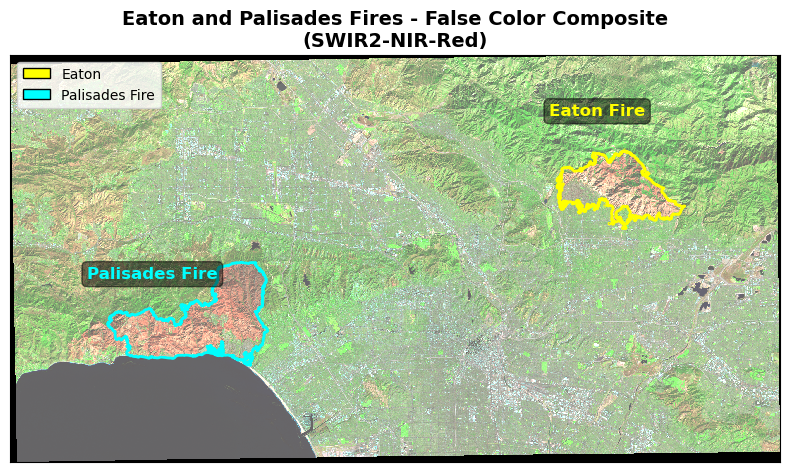

In [14]:
# Fill missing values with zero
landsat8 = landsat8.fillna(0)

# create figure 
fig, ax = plt.subplots(figsize= (8, 10))

# Plot false color image swir22/nir08/red 
landsat8[["swir22", "nir08", "red"]].to_array().plot.imshow(
ax = ax,
robust= True)

# Plot fire perimeters
eaton.plot(ax=ax, facecolor= 'none', edgecolor= 'yellow', linewidth= 2, label= 'Eaton Fires')
palisades.plot(ax=ax, facecolor= 'none', edgecolor= 'cyan', linewidth= 2, label= 'Palisades Fires')

ax.set_title('Eaton and Palisades Fires - False Color Composite\n(SWIR2-NIR-Red)', 
             fontsize=14, fontweight='bold')
#ax.set_xlabel('Longitude')
#ax.set_ylabel('Latitude')

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("") 

eaton_patch = mpatches.Patch(facecolor = "yellow", edgecolor = "black", label= "Eaton")
palisades_patch = mpatches.Patch(facecolor = "cyan", edgecolor = "black", label= "Palisades Fire" )
#ax.legend(loc='upper right', fontsize=10)
ax.legend(handles = [eaton_patch, palisades_patch], loc='upper left', fontsize= 10) 

# Add text annotations to identify fires
ax.text(0.70, 0.85, 'Eaton Fire', transform=ax.transAxes, 
        fontsize=12, color='yellow', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
ax.text(0.10, 0.45, 'Palisades Fire', transform=ax.transAxes, 
        fontsize=12, color='cyan', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))

plt.tight_layout()
plt.show()

#### Figure Description
The map features a false-color composite created from Landsat 8 data, depicting the regions affected by the Eaton and Palisades Fires. By combining SWIR, NIR, and red spectral bands, the image accentuates differences between healthy vegetation and burned terrain. Areas with intact vegetation appear bright green due to strong NIR reflectance, while fire-damaged zones appear in shades of reddish brown. Yellow and red outlines mark the Eaton and Palisades fire perimeters, clearly showing the extent of each fire. This type of false-color imagery is widely used to assess burn severity and understand how landscapes recover over time.

# Identifying Affected Communities Using Spatial Analysis
This section demonstrates how to identify which census tracts were impacted by each fire and visualize socioeconomic vulnerability patterns in the affected areas.

**Step 1:** Spatial Join - Finding Intersecting Census Tracts
Use a spatial join to identify which census tracts intersect with each fire perimeter:

- `gpd.sjoin()` performs a spatial join - it matches features from two datasets based on their geographic relationship

- `predicate="intersects` means "include any census tract that touches or overlaps the fire boundary"

- This returns complete census tracts, even if only a small portion overlaps the fire

**Step 2:** Clipping - Precise Fire Impact Areas
Clip the census tracts to show only the portions actually within each fire perimeter:

- Clipping cuts the census tract geometries at the fire boundary, showing only the affected portions

- Spatial join includes entire census tracts, which can overestimate the impacted area

- For visualizing communities directly affected by fire, clipping provides more accurate spatial representation

**Step 3:** Visualize Clipped Areas
Create maps showing the precise areas affected by each fire:

**Step 4:** Add Geographic Context with Basemap
Add a real-world basemap to show where the fires occurred in LA County:

- Provides real-world geographic context (roads, cities, landmarks)

- Makes it easier to understand where fires occurred relative to populated areas

- This where `contextily` become needed `ctx` automatically fetches map tiles that match your data's extent and CRS

**Step 5:** Visualize Socioeconomic Vulnerability
Compare vulnerability indicators between the two fire areas using the Environmental Justice Index data:

**Why this matters** This visualization reveals whether the fires disproportionately affected vulnerable communities, which has important implications for:

Resource allocation for recovery efforts
Identifying communities needing additional support
Understanding environmental justice dimensions of wildfire impacts

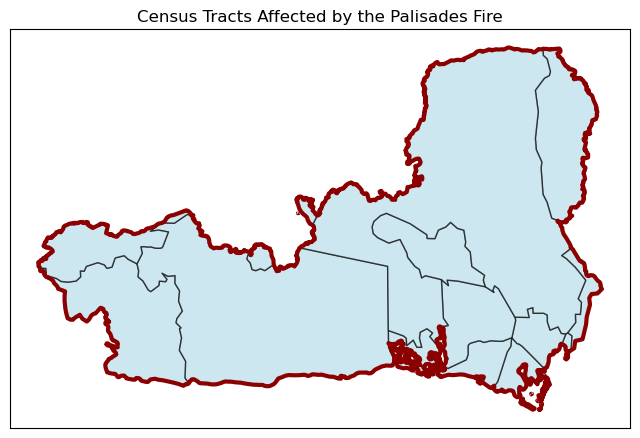

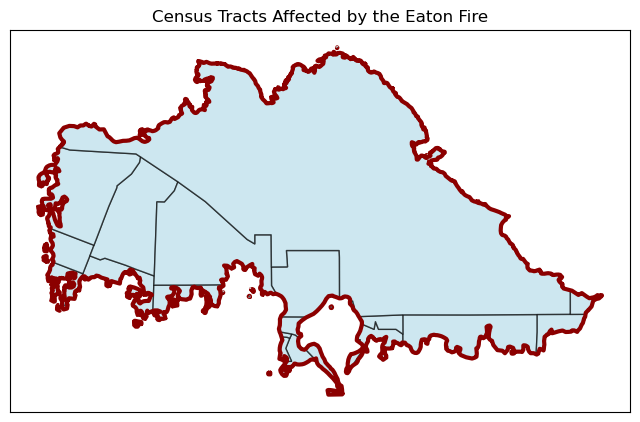

In [17]:
# Find census tracts that intersect with Palisades fire
eji_palisades = gpd.sjoin(cali_eji, palisades, predicate="intersects")

# Find census tracts that intersect with Eaton fire
eji_eaton = gpd.sjoin(cali_eji, eaton, predicate="intersects")
# Clip census tracts to Palisades fire boundary
eji_palisades_clip = gpd.clip(cali_eji, palisades)

# Clip census tracts to Eaton fire boundary
eji_eaton_clip = gpd.clip(cali_eji, eaton)

# Palisades Fire clipped census tracts
fig, ax = plt.subplots(figsize=(8, 10))

eji_palisades_clip.plot(ax=ax, facecolor="lightblue", edgecolor="black", linewidth=1, alpha=0.6)
palisades.plot(ax=ax, color="none", edgecolor="darkred", linewidth=3)

ax.set_title("Census Tracts Affected by the Palisades Fire")
ax.set_xticks([])
ax.set_yticks([])

plt.show()

# Eaton Fire clipped census tracts
fig, ax = plt.subplots(figsize=(8, 10))

eji_eaton_clip.plot(ax=ax, facecolor="lightblue", edgecolor="black", linewidth=1, alpha=0.6)
eaton.plot(ax=ax, color="none", edgecolor="darkred", linewidth=3)

ax.set_title("Census Tracts Affected by the Eaton Fire")
ax.set_xticks([])
ax.set_yticks([])

plt.show()

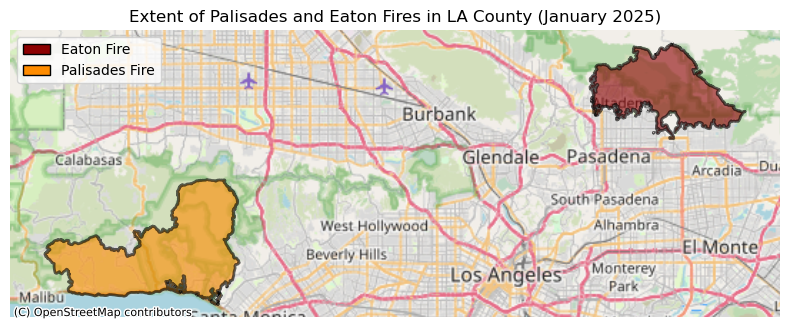

In [18]:
# Create figure
fig, ax = plt.subplots(figsize=(8, 10))

# Create legend patches
palisades_patch = mpatches.Patch(facecolor="darkorange", edgecolor="black", label="Palisades Fire")
eaton_patch = mpatches.Patch(facecolor="darkred", edgecolor="black", label="Eaton Fire")

# Plot fire perimeters
palisades.plot(ax=ax, facecolor="darkorange", edgecolor="black", alpha=0.6, linewidth=2)
eaton.plot(ax=ax, facecolor="darkred", edgecolor="black", alpha=0.6, linewidth=2)

# Add OpenStreetMap basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add legend and title
ax.legend(handles=[eaton_patch, palisades_patch], loc="upper left")
ax.set_title("Extent of Palisades and Eaton Fires in LA County (January 2025)")
ax.axis('off')

plt.tight_layout()
plt.show()

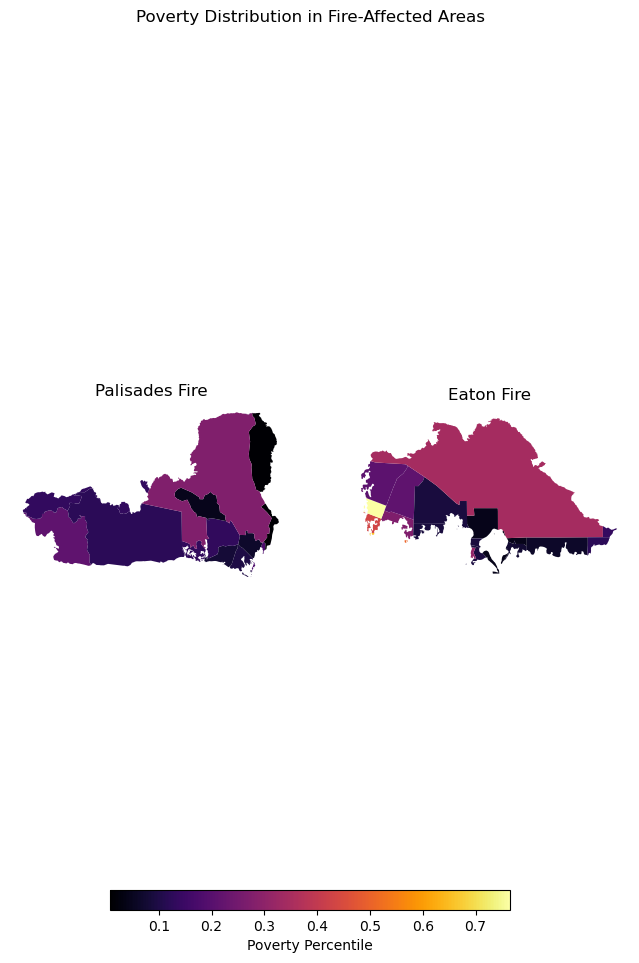

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 10))

# Select an EJI variable (e.g., poverty percentile)
eji_variable = 'EPL_POV200'

# Find common color scale range for both maps
vmin = min(eji_palisades_clip[eji_variable].min(), eji_eaton_clip[eji_variable].min())
vmax = max(eji_palisades_clip[eji_variable].max(), eji_eaton_clip[eji_variable].max())

# Plot Palisades census tracts colored by poverty level
eji_palisades_clip.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax1,
    cmap="inferno"
)
ax1.set_title('Palisades Fire')
ax1.axis('off')

# Plot Eaton census tracts colored by poverty level
eji_eaton_clip.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax2,
    cmap="inferno"
)
ax2.set_title('Eaton Fire')
ax2.axis('off')

# Add overall title
fig.suptitle('Poverty Distribution in Fire-Affected Areas')

# Add shared colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap="inferno")
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Poverty Percentile')

plt.show()